# Couple two models in *pymt*

In this example we will couple two components using *pymt*:

1. Coastline Evolution Model (CEM), which models the alongshore transport of sediment,
1. Waves model, which provides incoming wave direction and characteristics.

## The Coastline Evolution Model (CEM)

The Coastline Evolution Model (CEM) addresses predominately sandy, wave-dominated coastlines on time scales ranging from years to millenia and on spatial scales ranging from kilometers to hundreds of kilometers. Shoreline evolution results from gradients in wave-driven alongshore sediment transport.

At its most basic, the model follows the standard *one-line* modeling approach, where the cross-shore dimension is collapsed into a single data point. However, the model allows the planview shoreline to take on arbitrary local orientations, and even fold back upon itself, as complex shapes such as capes and spits form under some wave climates (distributions of wave influences from different approach angles). The model works on a two-dimensional grid.

CEM has been used to represent varying geology underlying a sandy coastline and shoreface in a simplified manner and enables the simulation of coastline evolution when sediment supply from an eroding shoreface may be constrained. CEM also supports the simulation of human manipulations to coastline evolution through beach nourishment or hard structures.

CEM authors & developers include:
* Andrew Ashton
* Brad Murray
* Jordan Slot
* Jaap Nienhuis and others.

This version is adapted from a CSDMS teaching notebook, listed below. 
It was created by Prof. Irina Overeem in October 2019 for a Sedimentary Modeling course.

### Key References

Ashton, A.D., Murray, B., Arnault, O. 2001. Formation of coastline features by large-scale instabilities induced by high-angle waves, Nature 414.

Ashton, A. D., and A. B. Murray (2006), High-angle wave instability and emergent shoreline shapes: 1. Modeling of sand waves, flying spits, and capes, J. Geophys. Res., 111, F04011, doi:10.1029/2005JF000422.


### Links

* [CEM source code](https://github.com/csdms/cem-old/tree/mcflugen/add-function-pointers): Look at the files that have *deltas* in their name.
* [CEM description on CSDMS](http://csdms.colorado.edu/wiki/Model_help:CEM): Detailed information on the CEM model.

### Interacting with the Coastline Evolution Model BMI using Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Import the `Cem` model into your environment.

In [2]:
import pymt.models
cem = pymt.models.Cem()

➡ models: Avulsion, Plume, Sedflux3D, Subside, Rafem, FrostNumber, Ku, Hydrotrend, GIPL, ECSimpleSnow, Child, Cem, Waves


Even though we can't run our model yet, we can still get some information about it, such as help and the names of the input variables and output variables.

In [3]:
cem.input_var_names

('sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity',
 'land_surface_water_sediment~bedload__mass_flow_rate',
 'sea_surface_water_wave__period',
 'sea_surface_water_wave__height',
 'land_surface__elevation',
 'model__time_step')

In [4]:
cem.output_var_names

('basin_outlet~coastal_center__x_coordinate',
 'basin_outlet~coastal_water_sediment~bedload__mass_flow_rate',
 'land_surface__elevation',
 'sea_water__depth',
 'basin_outlet~coastal_center__y_coordinate',
 'model__time_step')

We can also get information about specific variables. Here we'll look at some info about wave direction. This is the main input of the CEM model. What do you think the more conventional names for these variables are?

| Conventional Name      | Standard Name                                                       |
| :--------------------- | :------------------------------------------------------------------ |
| ???                    | sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity |
| ???                    | sea_surface_water_wave__period                                      |
| ???                    | sea_surface_water_wave__height                                      |

To help us out, we can get some additional information about each of the variables.

In [5]:
angle_name = 'sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity'

print("Data type: %s" % cem.var_type(angle_name))
print("Units: %s" % cem.var_units(angle_name))
print("Grid id: %d" % cem.var_grid(angle_name))
print("Number of elements in grid: %d" % cem.grid_node_count(0))
print("Type of grid: %s" % cem.grid_type(0))

Data type: float64
Units: radians
Grid id: 0
Number of elements in grid: 1
Type of grid: scalar


We now get the model ready for time stepping. Remember the lifecycle of the model is:
* *setup*
* *initialize*
* *update*
* *finalize*

For this example we'll set up a simulation with a grid of 100 rows and 200 columns with a grid
resolution of 200.0.

In [6]:
args = cem.setup(number_of_rows=100, number_of_cols=200, grid_spacing=200.)
cem.initialize(*args)

## Modifying a model's state

Because CEM has input variables (unlike *HydroTrend* in the previous example), we
are able to change variables inside the model. The is done with the ***set_value***
method.

For our first example we'll set the incoming wave height, period, and angle (in radians).

In [7]:
cem.set_value("sea_surface_water_wave__height", 1.5)
cem.set_value("sea_surface_water_wave__period", 7.)
cem.set_value("sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity", 0. * np.pi / 180.)

array([ 0.])

## Grids

This example is also different from the previous example in that it generates output that
is on a grid (as opposed to scalar data). The main output for CEM is *sea_water__depth*
on a grid whose size we set when we called *setup* for this simulation.

*pymt* models can have multiple grids. This allows for models to calculate some of
their state variables on scalars and others on 2D grids, for example. Models could also
maintain several grids of differing resolutions. In *pymt* each grid has an identifier
associated with it.

We use the ***var_grid*** function to get the grid ID.

In [8]:
cem.var_grid("sea_water__depth")

2

Once we have a grid ID, we can then use the *pymt* *grid_* methods to get additional information
about each of the grids. Because this grid is uniform rectilinear (as returned by the
***grid_type*** method below), it is described by a set of  methods that are only available
for grids of this type. These methods include:
* get_grid_shape
* get_grid_spacing
* get_grid_origin

In [9]:
print("Grid type: {0}".format(cem.grid_type(2)))
print("Grid rank: {0}".format(cem.grid_ndim(2)))
print("Grid shape: {0}".format(cem.grid_shape(2)))
print("Grid spacing: {0}".format(cem.grid_spacing(2)))
print("Grid origin: {0}".format(cem.grid_origin(2)))

Grid type: uniform_rectilinear
Grid rank: 2
Grid shape: [100 200]
Grid spacing: [ 200.  200.]
Grid origin: [ 0.  0.]


Now that we know a little more about the grid, let's plot it with the current values of
water depth.

Here I define a convenience function for plotting the water depth and making it look
pretty. You don't need to worry too much about it's internals for this tutorial.
It just saves typing later on.

In [10]:
def plot_coast(spacing, z):

    xmin, xmax = 0., z.shape[1] * spacing[0] * 1e-3
    ymin, ymax = 0., z.shape[0] * spacing[1] * 1e-3

    plt.imshow(z, extent=[xmin, xmax, ymin, ymax], origin="lower", cmap="ocean")
    plt.colorbar().ax.set_ylabel("Water Depth (m)")
    plt.xlabel("Along shore (km)")
    plt.ylabel("Cross shore (km)")

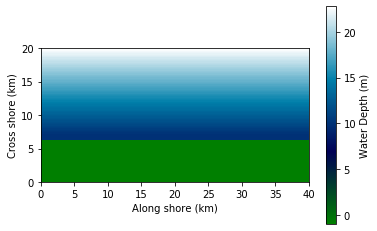

In [11]:
z = np.empty(cem.grid_shape(2), dtype=float)

cem.get_value("sea_water__depth", out=z)
plot_coast(cem.grid_spacing(2), z)

We have alredy set the incoming wave characteristics, but we've yet to add any sediment to
the system.

From the list of input variables, can you tell which one might be the one we're looking
for?

In [12]:
for name in cem.input_var_names:
    print("{0:70s} [{1}]".format(name, cem.var_units(name)))

sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity    [radians]
land_surface_water_sediment~bedload__mass_flow_rate                    [kg / s]
sea_surface_water_wave__period                                         [seconds]
sea_surface_water_wave__height                                         [meters]
land_surface__elevation                                                [meters]
model__time_step                                                       [d]


The one we want is *land_surface_water_sediment~bedload__mass_flow_rate*. Now have a look
at what sort of grid its defined on and how we could change its value.

In [13]:
cem.var_grid("land_surface_water_sediment~bedload__mass_flow_rate")

2

Notice that it's on the same grid as water depth. To add sediment, we need to:
1. allocate an array to hold sediment discharge values
2. set values of the sediment discharge array
3. pass this new sediment discharge array into CEM

I've placed the sediment discharge in the horizontal center of the grid (column 100 of 200) and
along the bottom. The sediment will be routed in a straight line until it hits the coast.

You don't need to do this, though. Feel free to add sediment in another location (or even multiple
locations!) or change the amount of sediment. Note that the CEM model is sensitive to the balance of
wave energy to sediment input. If you go too far from the defaults, you may get some "interesting"
results.

In [14]:
qs = np.zeros_like(z)
qs[0, 100] = 750
cem.set_value("land_surface_water_sediment~bedload__mass_flow_rate", qs)

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

Now let's time step through the model. For every iteration of the for-loop we set the sediment
discharge (***set_value***), and then update the model to the next time (***update_until***).

In [15]:
for time in range(3000):
    cem.set_value('land_surface_water_sediment~bedload__mass_flow_rate', qs)
    cem.update_until(time)
    if time % 100 == 0:
        print("time = {0}".format(time))

cem.get_value('sea_water__depth', out=z)

time = 0
time = 100
time = 200
time = 300
time = 400
time = 500
time = 600
time = 700
time = 800
time = 900
time = 1000
time = 1100
time = 1200
time = 1300
time = 1400
time = 1500
time = 1600
time = 1700
time = 1800
time = 1900
time = 2000
time = 2100
time = 2200
time = 2300
time = 2400
time = 2500
time = 2600
time = 2700
time = 2800
time = 2900


array([[ -1. ,  -1. ,  -1. , ...,  -1. ,  -1. ,  -1. ],
       [ -1. ,  -1. ,  -1. , ...,  -1. ,  -1. ,  -1. ],
       [ -1. ,  -1. ,  -1. , ...,  -1. ,  -1. ,  -1. ],
       ..., 
       [ 22.4,  22.4,  22.4, ...,  22.4,  22.4,  22.4],
       [ 22.6,  22.6,  22.6, ...,  22.6,  22.6,  22.6],
       [ 22.8,  22.8,  22.8, ...,  22.8,  22.8,  22.8]])

Let's have a look to see what sort of delta we've created after 3000.0 days.

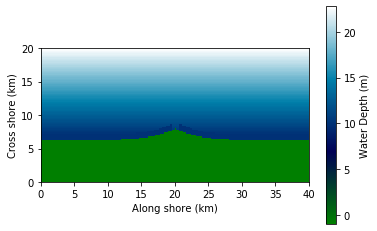

In [16]:
cem.get_value('sea_water__depth', out=z)
plot_coast(cem.grid_spacing(2), z)

## Exercise

Now play with the CEM model on your own. To make things easier, I've placed all of the steps
to run CEM into a single cell below. Please feel free to modify!

Some ideas
1. Modify wave energy vs sediment load
1. Change the incoming wave angle
1. Modify the river position so that it moves with time
1. Pick wave height and period from some probability density function
1. Add a second, or third, or fourth river
1. Increase the sediment load or have it vary with time
1. Make a movie of the evolving delta

Anything else?

In [17]:
import pymt.models
cem = pymt.models.Cem()

args = cem.setup(number_of_rows=100, number_of_cols=200, grid_spacing=200.)
cem.initialize(*args)

qs = np.zeros(cem.grid_shape(2), dtype=float)
qs[0, 100] = 750

for time in range(3000):
    cem.set_value("sea_surface_water_wave__height", 1.5)
    cem.set_value("sea_surface_water_wave__period", 7.)
    cem.set_value(
        "sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity",
        0. * np.pi / 180.,
    )

    cem.set_value('land_surface_water_sediment~bedload__mass_flow_rate', qs)
    cem.update_until(time)
    
    if time % 100 == 0:
        print("time = {0}".format(time))

time = 0
time = 100
time = 200
time = 300
time = 400
time = 500
time = 600
time = 700
time = 800
time = 900
time = 1000
time = 1100
time = 1200
time = 1300
time = 1400
time = 1500
time = 1600
time = 1700
time = 1800
time = 1900
time = 2000
time = 2100
time = 2200
time = 2300
time = 2400
time = 2500
time = 2600
time = 2700
time = 2800
time = 2900


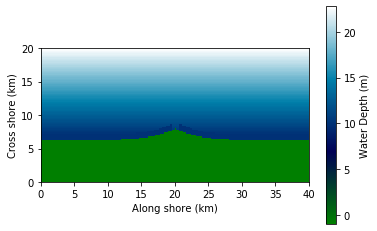

In [18]:
cem.get_value('sea_water__depth', out=z)
plot_coast(cem.grid_spacing(2), z)

In [19]:
def avulse_river(river_x, stddev=1.0, x_min=None, x_max=None):
    river_x += np.random.normal(0.0, stddev)
    if x_max is not None and river_x >= 200:
        river_x = river_x - 200
    if x_min is not None and river_x < 0:
        river_x = 200 + river_x
    return river_x

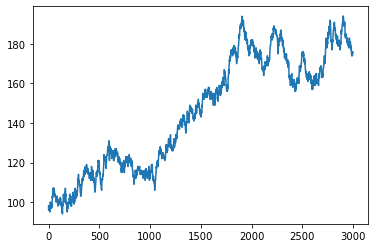

In [20]:
river_x = 100.0
river_i = []
for time in range(3000):
    river_x = avulse_river(river_x, x_min=0.0, x_max=200.0)
    river_i.append(int(river_x))
plt.plot(river_i)

## Exercise

### Couple models

Instead of using constant wave characteristics, let's now couple the CEM component with a wave
gererator component.

### Waves

In [21]:
from pymt.models import Waves

waves = Waves()
args = waves.setup(angle_asymmetry=0.2, angle_highness_factor=0.5)
waves.initialize(*args)

In [22]:
angles = np.zeros(1000)
for day in range(1000):
    waves.update()
    angles[day] = waves.get_value("sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity")

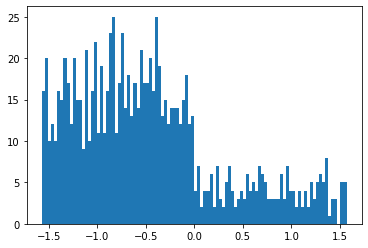

In [23]:
_ = plt.hist(angles, bins=100)

Now add the waves component to our coupling script.

In [24]:
import numpy as np
import pymt.models

waves = pymt.models.Waves()
args = waves.setup(angle_asymmetry=0.3, angle_highness_factor=0.7)
waves.initialize(*args)

cem = pymt.models.Cem()
args = cem.setup(number_of_rows=100, number_of_cols=200, grid_spacing=200.)
cem.initialize(*args)

qs = np.zeros(cem.grid_shape(2), dtype=float)
qs[0, 100] = 750

for time in range(3000):
    waves.update()
    angle = waves.get_value("sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity")
    
    cem.set_value("sea_surface_water_wave__height", 2.0)
    cem.set_value("sea_surface_water_wave__period", 7.0)
    cem.set_value(
        "sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity",
        angle,
    )

    cem.set_value('land_surface_water_sediment~bedload__mass_flow_rate', qs)
    cem.update_until(time)
    
    if time % 100 == 0:
        print("time = {0}".format(time))

time = 0
time = 100
time = 200
time = 300
time = 400
time = 500
time = 600
time = 700
time = 800
time = 900
time = 1000
time = 1100
time = 1200
time = 1300
time = 1400
time = 1500
time = 1600
time = 1700
time = 1800
time = 1900
time = 2000
time = 2100
time = 2200
time = 2300
time = 2400
time = 2500
time = 2600
time = 2700
time = 2800
time = 2900


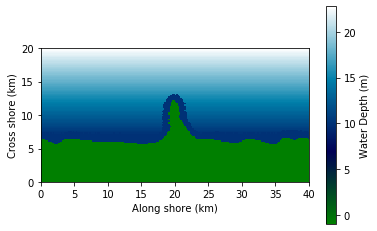

In [25]:
z = cem.get_value('sea_water__depth').reshape(cem.grid_shape(2))
plot_coast(cem.grid_spacing(2), z)